# Clustering Methods
### Methods Included: Louvain Clustering, Edge-Betweenness Clustering, and K-Clique Clustering

In [1]:
import networkx as nx
import itertools
import community #note: community installation requires running setup.py from https://github.com/taynaud/python-louvain/

## Louvain Clustering

In [2]:
def louvain_clustering(nxgraph):
    """Uses Lovain Clustering to find communities for all nodes in forest.
    
    Notes:
    Optimizes modularity (the measure of density of edges inside 
    community to edges outside communities)
    Implemented using community.best_partition method
    
    Parameters:
    nxgraph (networkx.Graph): a networkx graph object

    Returns:
    Sorted list of tuples, in which for each tuple, the first number
    is the node number and the second is the cluster number.
    
    """
    # Louvain clustering
    partition = community.best_partition(nxgraph)
    clusters = []
    cluster_data = []
    for com in set(partition.values()):
        list_nodes = [nodes for nodes in partition.keys() if partition.keys() if partition[nodes] == com]
        clusters.append(list_nodes)
    clusters.sort(key=lambda a: -len(a)) 

    # write out cluster information
    for i, cluster in enumerate(clusters):
        for node in cluster:
            cluster_data.append((i,node))
    return cluster_data

## Edge-Betweenness Clustering

In [3]:
def girvan_newman(G, most_valuable_edge=None):
    """Finds communities in a graph using the Girvan–Newman method.
    
    Notes:
    The Girvan–Newman algorithm detects communities by progressively
    removing edges from the original graph. The algorithm removes the
    "most valuable" edge, traditionally the edge with the highest
    betweenness centrality, at each step. As the graph breaks down into
    pieces, the tightly knit community structure is exposed and the
    result can be depicted as a dendrogram.

    Parameters:
    G : NetworkX graph

    most_valuable_edge : function
        Function that takes a graph as input and outputs an edge. The
        edge returned by this function will be recomputed and removed at
        each iteration of the algorithm.

        If not specified, the edge with the highest
        :func:`networkx.edge_betweenness_centrality` will be used.

    Returns:
    iterator
        Iterator over tuples of sets of nodes in `G`. Each set of node
        is a community, each tuple is a sequence of communities at a
        particular level of the algorithm.

    """
    # If the graph is already empty, simply return its connected
    # components.
    if G.number_of_edges() == 0:
        yield tuple(nx.connected_components(G))
        return
    # If no function is provided for computing the most valuable edge,
    # use the edge betweenness centrality.
    if most_valuable_edge is None:
        def most_valuable_edge(G):
            """Returns the edge with the highest betweenness centrality
            in the graph `G`.
            """
            # We have guaranteed that the graph is non-empty, so this
            # dictionary will never be empty.
            betweenness = nx.edge_betweenness_centrality(G)
            return max(betweenness, key=betweenness.get)
    # The copy of G here must include the edge weight data.
    g = G.copy().to_undirected()
    # Self-loops must be removed because their removal has no effect on
    # the connected components of the graph.
    g.remove_edges_from(g.selfloop_edges())
    while g.number_of_edges() > 0:
        yield _without_most_central_edges(g, most_valuable_edge)

def _without_most_central_edges(G, most_valuable_edge):
    """Returns the connected components of the graph that results from
    repeatedly removing the most "valuable" edge in the graph.

    Notes:
    `most_valuable_edge` is a function that takes the graph `G` as input
    (or a subgraph with one or more edges of `G` removed) and returns an
    edge. That edge will be removed and this process will be repeated
    until the number of connected components in the graph increases.


    Parameters:
    `G` must be a non-empty graph. This function modifies the graph `G`
    in-place; that is, it removes edges on the graph `G`.
    
    Returns:
    New_Components: Connected components of graph.

    """
    original_num_components = nx.number_connected_components(G)
    num_new_components = original_num_components
    while num_new_components <= original_num_components:
        edge = most_valuable_edge(G)
        G.remove_edge(*edge)
        new_components = tuple(nx.connected_components(G))
        num_new_components = len(new_components)
    return new_components

def most_central_edge(nxgraph):
    """Uses betweenness centrality to find the most central edge.
   
    Parameters:
    nxgraph (networkx.Graph): a networkx graph object
    
    Returns:
    edge: most central edge
    """
    
    centrality = nx.edge_betweenness_centrality(nxgraph, weight='weight')
    return max(centrality, key=centrality.get)

def betweenness_clustering(nxgraph, clusternum):
    """Clusters based on edge-betweenness, which finds the number 
    of shortest paths between pairs of nodes.
    
    Notes:
    Uses the Girvan-Newman algorith to calculate betwennness of all
    existing edges, remove edge with highest betweennnes, then recalculate 
    all affected edge betwennness scores, and repeat until no more edges remain

    Parameters: 
    clusternum: Number of clusters
    nxgraph (networkx.Graph): a networkx graph object
    
    Returns:
    Sorted list of tuples, in which for each tuple, the first number is
    the node number and the second is the cluster number.
    
    """
    cluster_data = []
    comp = girvan_newman(nxgraph, most_valuable_edge=most_central_edge)
    limited = itertools.takewhile(lambda c: len(c) <= clusternum, comp)
    for communities in limited:
        comm_arr = (tuple(sorted(c) for c in communities))
    try:
        for i in range(len(comm_arr)):
            for j in range(len(comm_arr[i])):
                curnode = (comm_arr[i])[j];
                cluster_data.append((i,curnode))
    except UnboundLocalError:
        print("Cluster number is too low to sufficiently use this method. Try a higher value")
    return cluster_data


## K-Clique Clustering

In [4]:
def kclique_clustering(nxgraph, clusterdist):
    """
    Notes: 
    K-clique clustering is useful in analyzing overlapping network
    community structure.
    The function finds K-clique communities, which are the union 
    of all cliques of size k that can 
    be reached through adjacent (sharing k-1 nodes) k-cliques

    Parameters: 
    clusterdist: Size of smallest clique desired
    nxgraph (networkx.Graph): a networkx graph object
    
    Returns:
    Sorted list of tuples, in which for each tuple, the first number 
    is the node number and the second is the cluster number.
    
    """
    cluster_data = []
    comp = list(nx.k_clique_communities(nxgraph, clusterdist))
    clusternum = len(list(comp))
    if clusternum>0:
        for j in range(clusternum):
            for k in range(len(list(list(comp)[j]))):
                curnode = ((list(list(comp)[j]))[k])
                cluster_data.append((j,curnode))
        return cluster_data 
    else:
        return 0

# Testing Clustering Methods

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotl

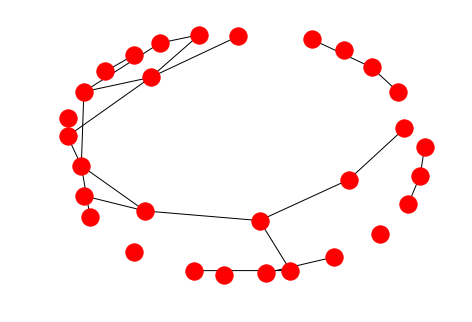

In [5]:
import matplotlib.pyplot as plt #only needed here for visualization
G = nx.erdos_renyi_graph(30, 0.05)

nx.draw(G)
plt.show()

In [7]:
louvain_test = louvain_clustering(G)
print('louvain_test cluster list:{}'.format(louvain_test))

betweenness_test = betweenness_clustering(G, 12)
print('edge-betweenness cluster list:{}'.format(betweenness_test))

kclique_test = kclique_clustering(G, 2)
print('k-clique cluster list:{}'.format(kclique_test))

louvain_test cluster list:[(0, 1), (0, 5), (0, 16), (0, 26), (0, 28), (1, 3), (1, 18), (1, 19), (1, 20), (1, 29), (2, 4), (2, 6), (2, 7), (2, 12), (2, 22), (3, 9), (3, 13), (3, 24), (4, 11), (4, 15), (4, 23), (5, 0), (5, 21), (6, 14), (6, 25), (7, 2), (8, 8), (9, 10), (10, 17), (11, 27)]
edge-betweenness cluster list:[(0, 0), (0, 21), (1, 1), (1, 3), (1, 5), (1, 16), (1, 18), (1, 19), (1, 20), (1, 29), (2, 2), (3, 4), (3, 12), (3, 22), (3, 26), (3, 28), (4, 6), (4, 7), (5, 8), (6, 9), (6, 13), (6, 24), (7, 10), (8, 11), (8, 15), (8, 23), (9, 14), (9, 25), (10, 17), (11, 27)]
k-clique cluster list:[(0, 1), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 12), (0, 16), (0, 18), (0, 19), (0, 20), (0, 22), (0, 26), (0, 28), (0, 29), (1, 15), (1, 11), (1, 23), (2, 0), (2, 21), (3, 25), (3, 14), (4, 24), (4, 9), (4, 13)]
